# Annual Buy & Hold Strategy

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from buy_and_hold import BuyAndHoldStrategy
from scipy.stats.mstats import gmean

In [2]:
data = pd.read_csv("buy_and_hold_prices.csv", index_col = "Date") 
#database of NASDAQ100 stocks from yahoo (Adj Close)
data.index = pd.to_datetime(data.index)

## Strategy:

In this strategy we buy stock yearly, the default annual investment is set to 10000 USD. 

We buy 5 stocks which were "the best" and hold them. Every year we add new stocks to our portfolio. "The best" mean that the stock daily returns were most often higher than $q$-th percentile of all daily returns for the last $w$ trading days.

#### Results:

We will use the window of 100 trading days and 90% percentile (see parameter optimization).

Strategy results (trading from 2006/1/3+ 100 days):

[*********************100%***********************]  1 of 1 downloaded

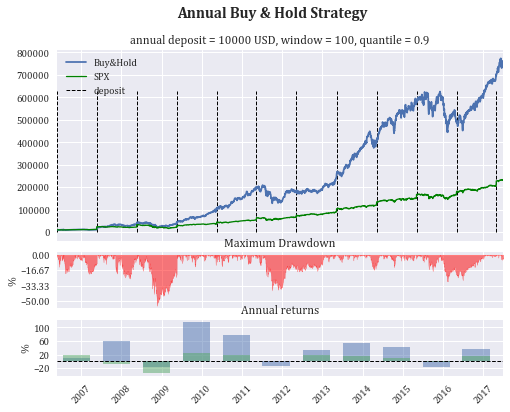

In [3]:
strategy = BuyAndHoldStrategy(data)
strategy.plot()

In `strategy.summary` you can see the number of bought stocks every year. The whole portfolio is cumulating those stocks.

In [4]:
strategy.summary

,Stock 1,Stock 2,Stock 3,Stock 4,Stock 5
2006-05-25,243 BIDU,152 ILMN,302 MNST,78 STX,56 VRTX
2007-05-24,136 BIDU,67 JBHT,540 NFLX,104 REGN,304 SWKS
2008-05-21,365 AAL,59 BIDU,40 MELI,224 MU,449 NFLX
2009-05-19,609 AAL,389 MU,6119 SIRI,264 STX,46 WYNN
2010-05-17,300 AAL,143 INCY,189 MU,2102 SIRI,104 TMUS
2011-05-12,206 AAL,93 INCY,61 NFLX,101 NVDA,837 SIRI
2012-05-09,225 AAL,284 MU,16 REGN,64 STX,72 SWKS
2013-05-09,119 AAL,81 EA,68 FB,207 MU,69 NFLX
2014-05-07,49 AAL,77 CTRP,15 ILMN,42 INCY,10 TSLA
2015-05-05,41 AAL,17 BMRN,23 INCY,21 SWKS,8 TSLA


In [5]:
strategy.annual_returns

,returns
Date,
2007-05-24,0.088199
2008-05-21,0.584995
2009-05-19,-0.169430
2010-05-17,1.152792
2011-05-12,0.776229
2012-05-09,-0.139292
2013-05-09,0.336391
2014-05-07,0.526393
2015-05-05,0.410367



## Parameter Optimization

In this part we search for "best" parameters (window $w$ and quantile $q$). 

We start with $w \in \{50,60,70,80,90,100,110,120\}$ and $q \in \{0.75,0.8,0.85,0.9,0.95\}$.

In [6]:
windows = np.array([50,60,70,80,90,100,110,120])
quantiles = np.array([0.75,0.8,0.85,0.9,0.95])

In [7]:
#optimization on 1/2006-6/2017 = ALL
returns_all = {}
start_time = time.time()
for w in range(len(windows)):
    ret_row = []
    for q in range(len(quantiles)):
        s = BuyAndHoldStrategy(data, window=windows[w], quantile=quantiles[q],
                               spx = False, maxdrawdown = False)
        ret_row.append(gmean(s.annual_returns+1)-1)
    returns_all[windows[w]] = ret_row
print("Computation time: " + str(np.round(time.time() - start_time,2)))

Computation time: 65.51


In [8]:
returns_all = pd.DataFrame(returns_all, index=quantiles)
returns_all.columns = windows
returns_all = returns_all.astype(np.float64)

Using the whole database - prices from 1/2006 to 6/2017 (market crash included). According to the following table and previous analysis (not in this document) we will do robust optimization for $w\in\{100,110,120\}$ and $q\in\{0.85,0.9\}$

In [9]:
returns_all

,50,60,70,80,90,100,110,120
0.75,0.216485,0.208510,0.220977,0.212223,0.206041,0.225723,0.234403,0.227274
0.80,0.262325,0.229024,0.266106,0.228359,0.252964,0.277138,0.290314,0.256150
0.85,0.257073,0.234795,0.225910,0.223233,0.236734,0.266341,0.273733,0.262226
0.90,0.277130,0.279556,0.273952,0.245924,0.244265,0.285492,0.294735,0.310125
0.95,0.271288,0.279548,0.273193,0.276742,0.228267,0.268474,0.276505,0.278940


In [10]:
window_int = [100,110,120]
quantile_int = [0.85,0.9]

In robust optimization we start trading at random dates before market crash, to see the progress of the Annual Buy & Hold Strategy. We generate 50 random starts from interval (1/2006,12/2007). The database will be from 1/2006 to 6/2009.

In [11]:
start_dates = np.random.randint(0,500,50)

In [12]:
start_dates = np.sort(data.index[start_dates])

In [13]:
#grid search on 1/2006-6/2009 = WORST CASE random starts ... ROBUST 
start_time = time.time()
ret = []
for start in start_dates:
    returns = {}
    for w in range(len(window_int)):
        ret_row = []
        for q in range(len(quantile_int)):
            s = BuyAndHoldStrategy(data[start:dt.date(2009,6,30)], window=windows[w], 
                                   quantile=quantiles[q], spx = False, 
                                   maxdrawdown = False)
            ret_row.append(gmean(s.annual_returns+1)-1)
        returns[windows[w]] = ret_row
    returns = pd.DataFrame(returns, index=quantile_int)
    returns.columns = window_int
    returns = returns.astype(np.float64)
    ret.append(returns)

print("Computation time: " + str(np.round(time.time() - start_time,2)))

Computation time: 120.99


In [14]:
arr = []
for i in range(len(start_dates)):
    arr.append(np.array(ret[i]))

In [15]:
arr = np.array(arr)

In [16]:
output = pd.Panel(arr, items=start_dates, 
                  major_axis=quantile_int, 
                  minor_axis=window_int)

In [17]:
print("Mean of 50 average returns:")
pd.DataFrame(np.mean(output, axis = 0), index=quantile_int, 
             columns=window_int)

Mean of 50 average returns:


,100,110,120
0.85,-0.131546,-0.140864,-0.152895
0.90,-0.145704,-0.166920,-0.170545


In [18]:
print("Window length:")
pd.Series(np.mean(np.mean(output, axis = 0), axis = 0), 
          index=window_int)

Window length:


100   -0.138625
110   -0.153892
120   -0.161720
dtype: float64

In [19]:
print("Quantile:")
pd.Series(np.mean(np.mean(output, axis = 0), axis = 1), 
          index = quantile_int)

Quantile:


0.85   -0.141768
0.90   -0.161056
dtype: float64

From worst case optimization (financial crisis) we can see better performance for $w = 100$ and $q = 0.85$. The same robust optimization for the whole database.

In [20]:
#grid search on 1/2006-6/2017 =  random starts ... ALL TIME ROBUST 
start_time = time.time()
ret2 = []
for start in start_dates:
    returns = {}
    for w in range(len(window_int)):
        ret_row = []
        for q in range(len(quantile_int)):
            s = BuyAndHoldStrategy(data[start:], window=windows[w], 
                                   quantile=quantiles[q], spx = False, 
                                   maxdrawdown = False)
            ret_row.append(gmean(s.annual_returns+1)-1)
        returns[windows[w]] = ret_row
    returns = pd.DataFrame(returns, index=quantile_int)
    returns.columns = window_int
    returns = returns.astype(np.float64)
    ret2.append(returns)

print("Computation time: " + str(np.round(time.time() - start_time,2)))

Computation time: 468.1


In [21]:
arr = []
for i in range(len(start_dates)):
    arr.append(np.array(ret2[i]))
arr = np.array(arr)
output2 = pd.Panel(arr, items=start_dates, major_axis=quantile_int, 
                   minor_axis=window_int)

In [22]:
print("Mean of 50 average returns:")
pd.DataFrame(np.mean(output2, axis = 0), index=quantile_int, 
             columns=window_int)

Mean of 50 average returns:


,100,110,120
0.85,0.228933,0.229264,0.233507
0.90,0.233045,0.234029,0.237084


In [23]:
print("Window length:")
pd.Series(np.mean(np.mean(output2, axis = 0), axis = 0), 
          index=window_int )

Window length:


100    0.230989
110    0.231647
120    0.235296
dtype: float64

In [24]:
print("Quantile:")
pd.Series(np.mean(np.mean(output2, axis = 0), axis = 1), 
          index = quantile_int)

Quantile:


0.85    0.230568
0.90    0.234719
dtype: float64

Differences in robust all time optimization are very small. We choose $w=100$ because of better performence in worst case and $q=0.9$ because of better performance in all time.